In [1]:
import numpy as np
import scipy
import scipy.io as sio
import matplotlib.pyplot as plt
import nibabel as nib

import os
from os.path import join as opj
from os.path import join, exists, split
import time
import urllib.request
import warnings
from tqdm import tqdm
from pprint import pprint
import zipfile
import glob
warnings.filterwarnings('ignore')
from transformers import AutoFeatureExtractor, ClapModel
import torch
import torchaudio

from sklearn.linear_model import LogisticRegression, RidgeCV, Ridge
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder


import pandas as pd
from nilearn import maskers
from nilearn import plotting
import tqdm

from nilearn.glm.first_level import FirstLevelModel
from nilearn.image import concat_imgs, mean_img
import matplotlib.pyplot as plt
import nilearn
from nilearn.plotting import plot_design_matrix
from nilearn.plotting import plot_contrast_matrix
from importlib import reload # python 2.7 does not require this
from data_agg import *
import pickle
from nltools.data import Brain_Data, Adjacency
from nltools.stats import align

import seaborn as sns
import IPython.display as ipd
from sklearn.metrics import confusion_matrix

In [2]:
def load_transformed_data(data_folder):
    # Initialize an empty dictionary to store the data
    loaded_data_dict = {}

    # Loop through all files in the data folder
    for filename in os.listdir(data_folder):
        # Construct the full path of the file
        file_path = os.path.join(data_folder, filename)
        
        # Extract the subject ID and key from the filename
        # Assuming filenames are in the format 'sub_key.ext'
        sub, key = filename.split('_', 1)
        key = key.rsplit('.', 1)[0]  # Removes extension part to get the key
        
        #repeat
        key = key.rsplit('.', 1)[0]  # Removes extension part to get the key

        # Initialize sub dictionary if it doesn't exist
        if sub not in loaded_data_dict:
            loaded_data_dict[sub] = {}

        # Determine the file type and load accordingly
        if filename.endswith('.npy'):
            loaded_data_dict[sub][key] = np.load(file_path)
        elif filename.endswith('.pkl'):
            with open(file_path, 'rb') as file:
                loaded_data_dict[sub][key] = pickle.load(file)

        print(f"Loaded {key} from {file_path}")

    return loaded_data_dict


In [3]:
transform_masking=True
subject_ids = ["sub-001", "sub-002", "sub-003", "sub-004", "sub-005"]

with open('/data01/data/fMRI_music_genre/data_dict' + '.pkl', 'rb') as file_to_read:
    data_dict = pickle.load(file_to_read)

with open('/data01/data/fMRI_music_genre/working_data_dict' + '.pkl', 'rb') as file_to_read:
    working_data_dict = pickle.load(file_to_read)

if transform_masking:
    base_masker=working_data_dict["sub-001"]["masker"]
    selected_indices=base_masker.transform(nib.load("mask_01.nii.gz"))
    for sub in subject_ids:
        working_data_dict[sub]["train_fmri_avg"]=working_data_dict[sub]["train_fmri"].squeeze()[:,selected_indices.squeeze().astype(np.uint8)]
        working_data_dict[sub]["test_fmri_avg"]=working_data_dict[sub]["test_fmri"].squeeze()[:,selected_indices.squeeze().astype(np.uint8)]
        # working_data_dict[sub]["train_fmri_avg"]=working_data_dict[sub]["train_fmri"].squeeze()[:,:,selected_indices.squeeze().astype(np.uint8)]
        # working_data_dict[sub]["test_fmri_avg"]=working_data_dict[sub]["test_fmri"].squeeze()[:,:,selected_indices.squeeze().astype(np.uint8)]

if transform_masking:
    # Ensure the data directory exists
    data_folder = 'data'
    os.makedirs(data_folder, exist_ok=True)

    # Assuming working_data_dict is your main dictionary and 'sub' is defined
    for sub in subject_ids:
        for key, value in working_data_dict[sub].items():
            # Convert the value to a numpy array if it's not already one 
            print(key)

            # Define the path for the output file
            file_path = os.path.join(data_folder, f'{sub}_{key}.npy')

            # Check if the value is a numpy array
            if isinstance(value, np.ndarray):
                # Save the numpy array to a file with .npy extension
                np.save(file_path + '.npy', value)
                print(f"Saved {key} as an array to {file_path}.npy")
            else:
                # Save other types of data using pickle with .pkl extension
                with open(file_path + '.pkl', 'wb') as file:
                    pickle.dump(value, file, protocol=pickle.HIGHEST_PROTOCOL)
                print(f"Saved {key} using pickle to {file_path}.pkl")

            print(f"Saved {key} to {file_path}")      

else:
    # Use the function
    data_folder = 'data'  # Specify the data folder path
    working_data_dict = load_transformed_data(data_folder)

train_fmri
Saved train_fmri using pickle to data/sub-001_train_fmri.npy.pkl
Saved train_fmri to data/sub-001_train_fmri.npy
train_audio_feat
Saved train_audio_feat using pickle to data/sub-001_train_audio_feat.npy.pkl
Saved train_audio_feat to data/sub-001_train_audio_feat.npy
train_genre
Saved train_genre using pickle to data/sub-001_train_genre.npy.pkl
Saved train_genre to data/sub-001_train_genre.npy
train_audio
Saved train_audio using pickle to data/sub-001_train_audio.npy.pkl
Saved train_audio to data/sub-001_train_audio.npy
test_fmri
Saved test_fmri using pickle to data/sub-001_test_fmri.npy.pkl
Saved test_fmri to data/sub-001_test_fmri.npy
test_audio_feat
Saved test_audio_feat using pickle to data/sub-001_test_audio_feat.npy.pkl
Saved test_audio_feat to data/sub-001_test_audio_feat.npy
test_genre
Saved test_genre using pickle to data/sub-001_test_genre.npy.pkl
Saved test_genre to data/sub-001_test_genre.npy
test_audio
Saved test_audio using pickle to data/sub-001_test_audio.npy.

In [4]:
df_captions = pd.read_csv('/srv/nfs-data/sisko/matteoc/music' + '/brain2music-captions.csv')
print(df_captions.head())
captions_array = df_captions.to_numpy()
caption_dict = {item[0].split('_')[0]: item[1] for item in captions_array}

for subj in subject_ids:

    train_stim_name_list = working_data_dict[subj]['train_stim_name']
    train_stim_caption_list = []

    for file_path in train_stim_name_list:
        genre_number = file_path.split('/')[-1].replace('.wav', '')
        caption = caption_dict.get(genre_number, "Caption not found")
        train_stim_caption_list.append(caption)

    working_data_dict[subj]['train_stim_caption'] = train_stim_caption_list


for subj in subject_ids:

    test_stim_name_list = working_data_dict[subj]['test_stim_name']
    test_stim_caption_list = []

    for file_path in test_stim_name_list:
        genre_number = file_path.split('/')[-1].replace('.wav', '')
        caption = caption_dict.get(genre_number, "Caption not found")
        test_stim_caption_list.append(caption)

    working_data_dict[subj]['test_stim_caption'] = test_stim_caption_list



                ID                                             DescEN
0  blues.00000_15s  Heavy blues with male vocals. Simple cutting w...
1  blues.00002_15s  Rhythmic blues. Obligatory trumpet obbligato a...
2  blues.00005_15s  Slow blues musical piece. Sentimental atmosphe...
3  blues.00006_15s  This blues is played with twin guitars only. T...
4  blues.00010_15s  This is an instrumental piece with electric gu...


In [5]:
import pandas as pd

def process_data(data_dict, key_suffix, features_key, genre_key, stim_name_key, fmri_key, stim_caption_key):
    # Create DataFrame for fMRI and stimulus names
    df = pd.DataFrame(data_dict[fmri_key], dtype=float)
    df['Stimulus'] = data_dict[stim_name_key]
    
    # Group by 'Caption' and calculate the mean for fMRI data
    fmri_avg = df.groupby('Stimulus').mean().reset_index()
    
    # Create DataFrame for audio features and stimulus names
    df_features = pd.DataFrame(data_dict[features_key], dtype=float)
    df_features['Stimulus'] = data_dict[stim_name_key]
    
    # Group by 'Caption' and calculate the mean for audio features
    features_avg = df_features.groupby('Stimulus').mean().reset_index()
    
    # Handle genres (assuming genre data is aligned with stimuli names)
    df_genre = pd.DataFrame(data_dict[genre_key], columns=['Genre'])
    df_genre['Stimulus'] = data_dict[stim_name_key]
    
    # Since genre should be consistent for the same caption, we can take the first occurrence
    genre_avg = df_genre.groupby('Stimulus').first().reset_index()

    # Handle genres (assuming genre data is aligned with stimuli names)
    df_caption = pd.DataFrame(data_dict[stim_caption_key], columns=['Caption'])
    df_caption['Stimulus'] = data_dict[stim_name_key]
    
    # Since genre should be consistent for the same caption, we can take the first occurrence
    caption_avg = df_caption.groupby('Stimulus').first().reset_index()
    
    return {
        key_suffix + '_audio_feat': features_avg.drop(columns='Stimulus').values,
        key_suffix + '_genre': genre_avg['Genre'].values,
        key_suffix + '_stim_name_avg': fmri_avg['Stimulus'].values,
        key_suffix + '_caption_avg': caption_avg['Caption'].values,
        key_suffix + '_fmri_avg': fmri_avg.drop(columns='Stimulus').values
    }


working_data_dict_avg = {}
for sub in subject_ids:
    working_data_dict_avg[sub] = {}

    # Process training data
    working_data_dict_avg[sub].update(
        process_data(
            working_data_dict[sub],
            'train',
            'train_audio_feat',
            'train_genre',
            'train_stim_name',
            'train_fmri_avg',
            'train_stim_caption'
        )
    )

    # Process testing data
    working_data_dict_avg[sub].update(
        process_data(
            working_data_dict[sub],
            'test',
            'test_audio_feat',
            'test_genre',
            'test_stim_name',
            'test_fmri_avg',
            'test_stim_caption'
        )
    )



In [6]:
# Function to print dimensions and examples
def print_key_details(data_dict):
    for key, value in data_dict.items():
        # Print the dimensions of each item
        if isinstance(value, np.ndarray):
            print(f"Key: {key}, Dimensions: {value.shape}")
        else:
            print(f"Key: {key}, Type: {type(value)}")
        
        # Print some example data for genre and stimuli names
        if 'genre' in key or 'stim_name' in key:
            print(f"Example data for {key}: {value[:5]}")  # Print first 5 examples

for sub in subject_ids:
    # Assuming working_data_dict_avg is already populated and structured correctly
    print_key_details(working_data_dict_avg[sub])

import pickle
import os


save_out_data=True

if save_out_data:
    # Ensure the 'data' directory exists
    if not os.path.exists('data'):
        os.makedirs('data')

    # Path to save the pickle file
    pickle_file_path = 'data/working_data_dict_avg.pkl'

    # Serialize and save the dictionary using pickle
    with open(pickle_file_path, 'wb') as file:
        pickle.dump(working_data_dict_avg, file)

    print(f'Data successfully saved to {pickle_file_path}')
    
else:
    # Path to the pickle file
    pickle_file_path = 'data/working_data_dict_avg.pkl'

    # Deserialize the dictionary from the pickle file
    with open(pickle_file_path, 'rb') as file:
        working_data_dict_avg = pickle.load(file)

    print('Data successfully loaded.')
    print(working_data_dict_avg)  # Optionally print or inspect some part of the loaded data




Key: train_audio_feat, Dimensions: (480, 512)
Key: train_genre, Dimensions: (480,)
Example data for train_genre: ['blues' 'blues' 'blues' 'blues' 'blues']
Key: train_stim_name_avg, Dimensions: (480,)
Example data for train_stim_name_avg: ['/data01/data/fMRI_music_genre/data_wav/genres_original/blues/blues.00000.wav'
 '/data01/data/fMRI_music_genre/data_wav/genres_original/blues/blues.00002.wav'
 '/data01/data/fMRI_music_genre/data_wav/genres_original/blues/blues.00005.wav'
 '/data01/data/fMRI_music_genre/data_wav/genres_original/blues/blues.00006.wav'
 '/data01/data/fMRI_music_genre/data_wav/genres_original/blues/blues.00010.wav']
Key: train_caption_avg, Dimensions: (480,)
Key: train_fmri_avg, Dimensions: (480, 833)
Key: test_audio_feat, Dimensions: (60, 512)
Key: test_genre, Dimensions: (60,)
Example data for test_genre: ['blues' 'blues' 'blues' 'blues' 'blues']
Key: test_stim_name_avg, Dimensions: (60,)
Example data for test_stim_name_avg: ['/data01/data/fMRI_music_genre/data_wav/gen

In [7]:
print(working_data_dict_avg['sub-001']['train_audio_feat'].shape)
print(working_data_dict_avg['sub-001']['train_fmri_avg'].shape)
print(working_data_dict_avg['sub-001']['train_genre'].shape)
print(working_data_dict_avg['sub-001']['train_stim_name_avg'].shape)
print(working_data_dict_avg['sub-001']['train_caption_avg'].shape)
print(working_data_dict_avg['sub-001']['test_audio_feat'].shape)
print(working_data_dict_avg['sub-001']['test_fmri_avg'].shape)
print(working_data_dict_avg['sub-001']['test_genre'].shape)
print(working_data_dict_avg['sub-001']['test_stim_name_avg'].shape)
print(working_data_dict_avg['sub-001']['test_caption_avg'].shape)


print(working_data_dict_avg['sub-001']['train_stim_name_avg'][94:98])
print(working_data_dict_avg['sub-001']['train_genre'][94:98])
print(working_data_dict_avg['sub-001']['train_caption_avg'][94:98])

(480, 512)
(480, 833)
(480,)
(480,)
(480,)
(60, 512)
(60, 833)
(60,)
(60,)
(60,)
['/data01/data/fMRI_music_genre/data_wav/genres_original/classical/classical.00095.wav'
 '/data01/data/fMRI_music_genre/data_wav/genres_original/classical/classical.00097.wav'
 '/data01/data/fMRI_music_genre/data_wav/genres_original/country/country.00006.wav'
 '/data01/data/fMRI_music_genre/data_wav/genres_original/country/country.00008.wav']
['classical' 'classical' 'country' 'country']
['This piece consists of several string instruments. A beautiful violin solo is heard. In the background, simple harmonies are playing. Suddenly an intense tone of multiple stringed instruments is heard, before returning to the original beautiful violin solo.'
 'The violin, harpsichord and cello are playing. The melody is performed by the violins. The tune transitions from minor to major and back to minor again.'
 'This is honest singing country. Light country guitar arpeggios and a harmonica can be heard. In the backgroun

In [8]:
# STRONGER FUNCTIONAL ALIGNMENT

target_sub="sub-001"

# X_train_aligned = [working_data_dict_avg[source_sub]["train_fmri_avg"]]
# X_test_aligned  = [working_data_dict_avg[source_sub]["test_fmri_avg"]]
X_train_aligned = []
X_test_aligned  = []


for source_sub in subject_ids:

    print(source_sub)
    source_train=working_data_dict_avg[source_sub]["train_fmri_avg"]
    target_train=working_data_dict_avg[target_sub]["train_fmri_avg"]

    source_test=working_data_dict_avg[source_sub]["test_fmri_avg"]
    target_test=working_data_dict_avg[target_sub]["test_fmri_avg"]

    
    aligner=RidgeCV(alphas=[1e2,1e3,1e4,5e4], fit_intercept=True)
    aligner.fit(source_train,target_train)

    aligned_source_test=aligner.predict(source_test)
    aligned_source_train=aligner.predict(source_train)

    aligned_source_train_adj = (aligned_source_train - aligned_source_train.mean(0)) / (1e-8 + aligned_source_train.std(0))
    aligned_source_train_adj = target_train.std(0) * aligned_source_train_adj + target_train.mean(0)

    # Align and adjust source_test dataset
    aligned_source_test_adj = (aligned_source_test - aligned_source_test.mean(0)) / (1e-8 + aligned_source_test.std(0))
    aligned_source_test_adj = target_train.std(0) * aligned_source_test_adj + target_train.mean(0)
    
    X_train_aligned.append(aligned_source_train_adj)
    X_test_aligned.append(aligned_source_test_adj)
    
#concatenate all

X_train_aligned = np.concatenate(X_train_aligned,0)
X_test_aligned = np.concatenate(X_test_aligned,0)

#concatenate all the other keys

train_audio_feat_aligned = np.concatenate([working_data_dict_avg[sub]["train_audio_feat"] for sub in subject_ids],0)
test_audio_feat_aligned = np.concatenate([working_data_dict_avg[sub]["test_audio_feat"] for sub in subject_ids],0)

train_genre_aligned = np.concatenate([working_data_dict_avg[sub]["train_genre"] for sub in subject_ids],0)
test_genre_aligned = np.concatenate([working_data_dict_avg[sub]["test_genre"] for sub in subject_ids],0)

train_stim_name_avg_aligned = np.concatenate([working_data_dict_avg[sub]["train_stim_name_avg"] for sub in subject_ids],0)
test_stim_name_avg_aligned = np.concatenate([working_data_dict_avg[sub]["test_stim_name_avg"] for sub in subject_ids],0)

train_caption_avg_aligned = np.concatenate([working_data_dict_avg[sub]["train_caption_avg"] for sub in subject_ids],0)
test_caption_avg_aligned = np.concatenate([working_data_dict_avg[sub]["test_caption_avg"] for sub in subject_ids],0)


sub-001
sub-002
sub-003
sub-004
sub-005


In [9]:
from diffusers import MusicLDMPipeline

repo_id = "ucsd-reach/musicldm"
pipe = MusicLDMPipeline.from_pretrained(repo_id, torch_dtype=torch.float16)
pipe = pipe.to("cuda")

from transformers import AutoFeatureExtractor, ClapModel, ClapProcessor

clap_model_id="laion/larger_clap_music_and_speech"
model = ClapModel.from_pretrained(clap_model_id).to("cuda")
processor = ClapProcessor.from_pretrained(clap_model_id)

# model = ClapModel.from_pretrained("laion/clap-htsat-unfused").to("cuda:1")
feature_extractor = AutoFeatureExtractor.from_pretrained(clap_model_id)

Loading pipeline components...: 100%|██████████| 7/7 [00:02<00:00,  3.32it/s]


In [10]:
train_text_ldm = []
with torch.no_grad():
    for tx in tqdm.tqdm(train_caption_avg_aligned):
        text_ldm = pipe._encode_prompt(tx, device='cuda', num_waveforms_per_prompt=1, do_classifier_free_guidance=False)
        train_text_ldm.append(text_ldm)

test_text_ldm = []
with torch.no_grad():
    for tx in tqdm.tqdm(test_caption_avg_aligned):
        text_ldm = pipe._encode_prompt(tx, device='cuda', num_waveforms_per_prompt=1, do_classifier_free_guidance=False)
        test_text_ldm.append(text_ldm)

train_text_feat_avg_aligned=torch.stack(train_text_ldm).squeeze()
test_text_feat_avg_aligned=torch.stack(test_text_ldm).squeeze()

100%|██████████| 300/300 [00:02<00:00, 149.36it/s]


## Fine Tuning on MusicCaps

In [12]:
from datasets import load_dataset

ds = load_dataset('google/MusicCaps', split='train')

In [13]:
import subprocess
import os
from pathlib import Path

def download_clip(
    video_identifier,
    output_filename,
    start_time,
    end_time,
    tmp_dir='/tmp/musiccaps/',
    num_attempts=5,
    url_base='https://www.youtube.com/watch?v='
):
    status = False

    command = f"""
        yt-dlp --quiet --no-warnings -x --audio-format wav -f bestaudio -o "{output_filename}" --download-sections "*{start_time}-{end_time}" {url_base}{video_identifier}
    """.strip()

    attempts = 0
    while True:
        try:
            output = subprocess.check_output(command, shell=True,
                                                stderr=subprocess.STDOUT)
        except subprocess.CalledProcessError as err:
            attempts += 1
            if attempts == num_attempts:
                return status, err.output
        else:
            break

    # Check if the video was successfully saved.
    status = os.path.exists(output_filename)
    return status, 'Downloaded'




In [14]:
from datasets import Audio

samples_to_load = 5521      # How many samples to load
cores = 4                 # How many processes to use for the loading
sampling_rate = 44100     # Sampling rate for the audio, keep in 44100
writer_batch_size = 1000  # How many examples to keep in memory per worker. Reduce if OOM.
data_dir = "/srv/nfs-data/sisko/matteoc/music/music_data_caps" # Where to save the data

# Just select some samples 
ds = ds.select(range(samples_to_load))

# Create directory where data will be saved
data_dir = Path(data_dir)
data_dir.mkdir(exist_ok=True, parents=True)

def process(example):
    outfile_path = str(data_dir / f"{example['ytid']}.wav")
    status = True
    if not os.path.exists(outfile_path):
        status = False
        status, log = download_clip(
            example['ytid'],
            outfile_path,
            example['start_s'],
            example['end_s'],
        )

    example['audio'] = outfile_path
    example['download_status'] = status
    return example



In [15]:
ds = ds.map(
        process,
        num_proc=cores,
        writer_batch_size=writer_batch_size,
        keep_in_memory=False
    ).cast_column('audio', Audio(sampling_rate=sampling_rate))

In [19]:
caps_audio = []
caps_sr = []
caps_caption = []
for i in tqdm.tqdm(range(len(ds))):
    try:
        audio, sr = torchaudio.load(ds[i]['audio']['path'])
        caption = ds[i]['caption']
        caps_audio.append(audio)
        caps_sr.append(sr)
        caps_caption.append(caption)
    except:
        continue


caps_audio_mono = []
for audio_stereo in caps_audio:
    mono_waveform = torch.mean(audio_stereo, dim=0, keepdim=True)
    caps_audio_mono.append(mono_waveform)


100%|██████████| 5521/5521 [05:37<00:00, 16.38it/s]


In [23]:
len(caps_audio_mono)

5402

In [24]:
audio_feat_caps=[]
text_feat_caps=[]
resampler = torchaudio.transforms.Resample(orig_freq=44100, new_freq=48000)

with torch.no_grad():
    for wv,tx,sr in tqdm.tqdm(list(zip(caps_audio_mono,caps_caption,caps_sr))):
        wv = resampler(wv)
        inputs = processor(text=tx, audios=wv.squeeze(), return_tensors="pt", sampling_rate=48_000)
        outputs = model(**inputs.to('cuda'))
        audio_feat_caps.append(outputs.audio_embeds)
        text_feat_caps.append(outputs.text_embeds)

  0%|          | 0/5402 [00:00<?, ?it/s]

100%|██████████| 5402/5402 [29:36<00:00,  3.04it/s]


In [25]:
audio_feat_caps=torch.stack(audio_feat_caps).squeeze()
# torch.save(audio_feat_caps, "/srv/nfs-data/sisko/matteoc/music/feature/audio_feat_clap_cap.pt")
# np.save('/srv/nfs-data/sisko/matteoc/music/feature/text_caption_cap.npy', caps_caption)

In [11]:
audio_feat_caps = torch.load("/srv/nfs-data/sisko/matteoc/music/feature/audio_feat_clap_cap.pt")
caps_caption = np.load('/srv/nfs-data/sisko/matteoc/music/feature/text_caption_cap.npy').tolist()

In [12]:
audio_feat_caps.shape

torch.Size([5402, 512])

In [13]:
text_feat_cap_ldm = []
with torch.no_grad():
    for tx in tqdm.tqdm(caps_caption):
        text_ldm = pipe._encode_prompt(tx, device='cuda', num_waveforms_per_prompt=1, do_classifier_free_guidance=False)
        text_feat_cap_ldm.append(text_ldm)

text_feat_cap_ldm=torch.stack(text_feat_cap_ldm).squeeze()


100%|██████████| 5402/5402 [00:36<00:00, 148.03it/s]


In [14]:
import torch.nn as nn
import torch.optim as optim

input_dim = 512
output_dim = 512
linear_layer = nn.Linear(input_dim, output_dim).to('cuda')
criterion = nn.MSELoss()
optimizer = optim.Adam(linear_layer.parameters(), lr=0.0001, weight_decay=1e-6)

# Training loop
num_epochs = 1000
for epoch in range(num_epochs):
    linear_layer.train()
    optimizer.zero_grad() 
    audio_feat_train_output = linear_layer(audio_feat_caps)
    loss = criterion(audio_feat_train_output, text_feat_cap_ldm.float()) 
    loss.backward()
    optimizer.step()
    
    if (epoch+1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item()}')



Epoch [20/1000], Loss: 0.0024276995100080967
Epoch [40/1000], Loss: 0.001921995310112834
Epoch [60/1000], Loss: 0.0016561527736485004
Epoch [80/1000], Loss: 0.0015026615001261234
Epoch [100/1000], Loss: 0.0014057285152375698
Epoch [120/1000], Loss: 0.0013401504838839173
Epoch [140/1000], Loss: 0.001293483655899763
Epoch [160/1000], Loss: 0.0012589714024215937
Epoch [180/1000], Loss: 0.0012326447758823633
Epoch [200/1000], Loss: 0.0012120302999392152
Epoch [220/1000], Loss: 0.0011955169029533863
Epoch [240/1000], Loss: 0.0011820201762020588
Epoch [260/1000], Loss: 0.0011707893572747707
Epoch [280/1000], Loss: 0.0011612933594733477
Epoch [300/1000], Loss: 0.0011531489435583353
Epoch [320/1000], Loss: 0.001146074035204947
Epoch [340/1000], Loss: 0.0011398582719266415
Epoch [360/1000], Loss: 0.0011343419319018722
Epoch [380/1000], Loss: 0.0011294020805507898
Epoch [400/1000], Loss: 0.0011249430244788527
Epoch [420/1000], Loss: 0.0011208889773115516
Epoch [440/1000], Loss: 0.001117179985158

## Contrastive Learning

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0,1,2,3,4,5,6,7]

  | Name  | Type    | Params
----------------------------------
0 | model | Encoder | 0     
----------------------------------
0         Trainable params
0         Non-trainable params
0         Total params
0.000     Total estimated model params size (MB)


Epoch 0:   0%|          | 0/169 [00:00<?, ?it/s]                            

Epoch 19: 100%|██████████| 169/169 [00:01<00:00, 138.89it/s, v_num=3, train_loss_step=0.676, val_loss=2.380, val_mse_loss=0.00212, val_cosine_similarity=0.122, train_loss_epoch=0.711] 

`Trainer.fit` stopped: `max_epochs=20` reached.


Epoch 19: 100%|██████████| 169/169 [00:01<00:00, 136.98it/s, v_num=3, train_loss_step=0.676, val_loss=2.380, val_mse_loss=0.00212, val_cosine_similarity=0.122, train_loss_epoch=0.711]


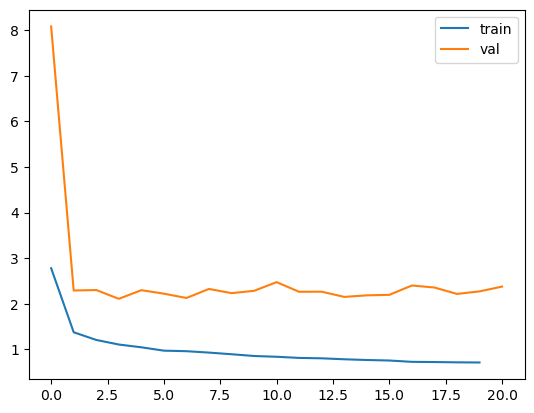

In [20]:
from networks import Encoder, ContrastiveModel
import pytorch_lightning as pl

train_dataset=torch.utils.data.TensorDataset(torch.Tensor(audio_feat_caps).float(), torch.Tensor(text_feat_cap_ldm).float(), torch.ones(len(audio_feat_caps))) 
test_dataset=torch.utils.data.TensorDataset(torch.Tensor(train_audio_feat_aligned).float(), torch.Tensor(train_text_feat_avg_aligned).float(),torch.ones(len(train_audio_feat_aligned)))

BS=64
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BS, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BS, shuffle=True)

align_model = ContrastiveModel(num_input_channels=audio_feat_caps.shape[-1], base_channel_size=[768], latent_dim=512,act_fn=torch.nn.GELU, loss_type="contrastive", common_dim=audio_feat_caps.shape[1])

# Instantiate a PyTorch Lightning Trainer
trainer = pl.Trainer(max_epochs=20, devices=[1])

# Train the model
trainer.fit(align_model, train_dataloader, test_dataloader)

plt.plot(align_model.train_history["train_loss"], label='train')
plt.plot(align_model.val_history["val_loss"], label='val')
plt.legend()




In [14]:
import torch
import torch.nn as nn
import torch.optim as optim


class LinearEmbeddingModel(nn.Module):
    def __init__(self, input_dim, output_dim):
        super(LinearEmbeddingModel, self).__init__()
        self.linear = nn.Linear(input_dim, output_dim)

    def forward(self, x):
        return self.linear(x)


class CosineContrastiveLoss(nn.Module):
    def __init__(self, input_dim, margin=0.5):
        super(CosineContrastiveLoss, self).__init__()
        self.margin = margin
        # self.W_i = nn.Parameter(torch.randn(input_dim, input_dim))  # Initialize W_i
        # self.W_t = nn.Parameter(torch.randn(input_dim, input_dim))  # Initialize W_t

    def forward(self, z_i, z_j):

        # Apply linear transformation using W_i
        # z_i = torch.matmul(z_i, self.W_i)
        # z_j = torch.matmul(z_j, self.W_t)

        z_i = nn.functional.normalize(z_i, dim=1)
        z_j = nn.functional.normalize(z_j, dim=1)

        logits = (z_i @ z_j.T) * np.exp(self.margin)
        targets = torch.arange(logits.shape[0]).long().to(logits.device)
        loss = torch.nn.functional.cross_entropy(logits, targets)

        return loss
    

def get_batch(data, batch_size):
    indices = torch.randperm(data.size(0))[:batch_size]
    batch = data[indices]
    return batch, indices

def get_batch_ordered(data, batch_size, start_index):
    end_index = start_index + batch_size
    batch = data[start_index:end_index]
    indices = torch.arange(start_index, end_index)
    return batch, indices




In [27]:
batch_size = 73    # if randomize --> batch_size = 50
input_dim = output_dim = 512
model_cl = LinearEmbeddingModel(input_dim, output_dim).to('cuda')
criterion_cl = CosineContrastiveLoss(input_dim, margin=5).to('cuda')     # margin = 5 is the optimal
optimizer_cl = optim.Adam(model_cl.parameters(), lr=0.0001, weight_decay=1e-6)     # lr = 0.0001 optimal 
num_epochs = 1000

In [28]:
for epoch in tqdm.tqdm(range(num_epochs)):
    model_cl.train()
    epoch_loss = 0

    for i in range(0, len(audio_feat_caps), batch_size):
        audio_batch, indices = get_batch(audio_feat_caps, batch_size)
        # audio_batch, indices = get_batch_ordered(audio_feat_caps, batch_size, i)
        text_batch = text_feat_cap_ldm[indices] 
        optimizer_cl.zero_grad()
        output1 = model_cl(audio_batch.float())
        loss = criterion_cl(output1, text_batch.float())
        loss.backward()
        optimizer_cl.step()
        epoch_loss += loss.item()

    if (epoch+1) % 20 == 0:
        print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss / (len(audio_feat_caps) // batch_size)}')

  2%|▏         | 21/1000 [00:03<02:19,  7.00it/s]

Epoch [20/1000], Loss: 0.9812020361423492


  4%|▍         | 41/1000 [00:06<02:14,  7.11it/s]

Epoch [40/1000], Loss: 0.4813344321540884


  6%|▌         | 61/1000 [00:09<02:12,  7.08it/s]

Epoch [60/1000], Loss: 0.22770283854491002


  8%|▊         | 81/1000 [00:12<02:09,  7.09it/s]

Epoch [80/1000], Loss: 0.48936056768572006


 10%|█         | 101/1000 [00:14<02:06,  7.11it/s]

Epoch [100/1000], Loss: 0.08154133329721722


 12%|█▏        | 121/1000 [00:17<02:05,  6.99it/s]

Epoch [120/1000], Loss: 0.16027960533628594


 14%|█▍        | 141/1000 [00:20<02:01,  7.08it/s]

Epoch [140/1000], Loss: 0.031471162228970916


 16%|█▌        | 161/1000 [00:23<01:57,  7.12it/s]

Epoch [160/1000], Loss: 0.021835382260080125


 18%|█▊        | 181/1000 [00:26<01:55,  7.07it/s]

Epoch [180/1000], Loss: 0.015398818370256875


 20%|██        | 201/1000 [00:28<01:21,  9.80it/s]

Epoch [200/1000], Loss: 0.9131522226852138


 22%|██▏       | 221/1000 [00:30<01:09, 11.14it/s]

Epoch [220/1000], Loss: 0.009367891071313942


 24%|██▍       | 241/1000 [00:32<01:08, 11.15it/s]

Epoch [240/1000], Loss: 0.006939466432290706


 26%|██▌       | 261/1000 [00:34<01:06, 11.11it/s]

Epoch [260/1000], Loss: 0.0057155622949672715


 28%|██▊       | 281/1000 [00:35<01:05, 11.06it/s]

Epoch [280/1000], Loss: 0.00480543336566739


 30%|███       | 301/1000 [00:37<01:02, 11.16it/s]

Epoch [300/1000], Loss: 0.0065281966172561455


 32%|███▏      | 321/1000 [00:39<00:59, 11.34it/s]

Epoch [320/1000], Loss: 0.003995773055263468


 34%|███▍      | 341/1000 [00:41<00:58, 11.28it/s]

Epoch [340/1000], Loss: 0.0031846122677765183


 36%|███▌      | 361/1000 [00:43<00:57, 11.06it/s]

Epoch [360/1000], Loss: 0.002758179440452541


 38%|███▊      | 381/1000 [00:44<00:55, 11.23it/s]

Epoch [380/1000], Loss: 0.00252404305895136


 40%|████      | 401/1000 [00:46<00:53, 11.13it/s]

Epoch [400/1000], Loss: 0.004156537070820057


 42%|████▏     | 421/1000 [00:48<00:51, 11.20it/s]

Epoch [420/1000], Loss: 0.002456236323908072


 44%|████▍     | 441/1000 [00:50<00:49, 11.24it/s]

Epoch [440/1000], Loss: 0.0018989180995000374


 46%|████▌     | 461/1000 [00:52<00:48, 11.17it/s]

Epoch [460/1000], Loss: 0.0016301623325341858


 48%|████▊     | 481/1000 [00:53<00:46, 11.22it/s]

Epoch [480/1000], Loss: 0.001507579691934626


 50%|█████     | 501/1000 [00:55<00:43, 11.35it/s]

Epoch [500/1000], Loss: 0.010064600444575017


 52%|█████▏    | 521/1000 [00:57<00:42, 11.33it/s]

Epoch [520/1000], Loss: 0.002135910796995803


 54%|█████▍    | 541/1000 [00:59<00:40, 11.24it/s]

Epoch [540/1000], Loss: 0.0014467874252413575


 56%|█████▌    | 561/1000 [01:00<00:39, 11.25it/s]

Epoch [560/1000], Loss: 0.0011512915520437968


 58%|█████▊    | 581/1000 [01:02<00:37, 11.20it/s]

Epoch [580/1000], Loss: 0.0010091648083117263


 60%|██████    | 601/1000 [01:04<00:35, 11.31it/s]

Epoch [600/1000], Loss: 0.0009555457674306692


 62%|██████▏   | 621/1000 [01:06<00:33, 11.19it/s]

Epoch [620/1000], Loss: 0.005675094246209876


 64%|██████▍   | 641/1000 [01:08<00:32, 11.19it/s]

Epoch [640/1000], Loss: 0.0016351302006483279


 66%|██████▌   | 661/1000 [01:09<00:30, 11.18it/s]

Epoch [660/1000], Loss: 0.0010714773961808532


 68%|██████▊   | 681/1000 [01:11<00:28, 11.18it/s]

Epoch [680/1000], Loss: 0.0008291387954110129


 70%|███████   | 701/1000 [01:13<00:26, 11.21it/s]

Epoch [700/1000], Loss: 0.0007107048826386548


 72%|███████▏  | 721/1000 [01:15<00:24, 11.25it/s]

Epoch [720/1000], Loss: 0.0006623541337683344


 74%|███████▍  | 741/1000 [01:16<00:23, 11.23it/s]

Epoch [740/1000], Loss: 0.5095264055841678


 76%|███████▌  | 761/1000 [01:18<00:21, 11.17it/s]

Epoch [760/1000], Loss: 0.0016772477695642894


 78%|███████▊  | 781/1000 [01:20<00:19, 11.16it/s]

Epoch [780/1000], Loss: 0.0009572690241101727


 80%|████████  | 801/1000 [01:22<00:17, 11.27it/s]

Epoch [800/1000], Loss: 0.0006927744531846681


 82%|████████▏ | 821/1000 [01:24<00:15, 11.26it/s]

Epoch [820/1000], Loss: 0.000561531594989041


 84%|████████▍ | 841/1000 [01:25<00:14, 11.20it/s]

Epoch [840/1000], Loss: 0.0004982623252765956


 86%|████████▌ | 861/1000 [01:27<00:12, 11.22it/s]

Epoch [860/1000], Loss: 0.0004855585831211175


 88%|████████▊ | 881/1000 [01:29<00:10, 11.17it/s]

Epoch [880/1000], Loss: 0.004009037099250064


 90%|█████████ | 901/1000 [01:31<00:08, 11.30it/s]

Epoch [900/1000], Loss: 0.0011226962378714234


 92%|█████████▏| 921/1000 [01:32<00:07, 11.23it/s]

Epoch [920/1000], Loss: 0.0006965370109380299


 94%|█████████▍| 941/1000 [01:34<00:05, 11.19it/s]

Epoch [940/1000], Loss: 0.0005112649720300593


 96%|█████████▌| 961/1000 [01:36<00:03, 11.32it/s]

Epoch [960/1000], Loss: 0.0004167283178823119


 98%|█████████▊| 981/1000 [01:38<00:01, 11.21it/s]

Epoch [980/1000], Loss: 0.0003716148993761807


100%|██████████| 1000/1000 [01:40<00:00, 10.00it/s]

Epoch [1000/1000], Loss: 0.0003654830963224978


In [29]:
train_audio_feat_aligned.shape

(2400, 512)

In [30]:
batch_size = 48

model_cl.eval()  
train_feature_finetuned=[]
with torch.no_grad():  
    for sliced in range(0, len(train_audio_feat_aligned), batch_size):
        audio_batch, indices = get_batch_ordered(torch.tensor(train_audio_feat_aligned), batch_size, sliced)
        text_batch = train_text_feat_avg_aligned[indices] 
        output1 = model_cl(torch.tensor(audio_batch, dtype=torch.float32, device='cuda:0'))
        # output2 = model_cl(torch.tensor(text_batch, dtype=torch.float32, device='cuda:0'))
        test_loss = criterion_cl(output1, text_batch.float())
        train_feature_finetuned.append(output1)
        
print(f'Test Loss: {test_loss.item()/ (len(train_audio_feat_aligned) // batch_size)}')

train_feature_finetuned=torch.cat(train_feature_finetuned,0)

Test Loss: 0.19709527969360352


In [31]:
batch_size = 20

model_cl.eval()  
test_feature_finetuned=[]
with torch.no_grad():  
    for sliced_test in range(0, len(test_audio_feat_aligned), batch_size):
        audio_batch, indices = get_batch_ordered(torch.tensor(test_audio_feat_aligned), batch_size, sliced_test)
        text_batch = test_text_feat_avg_aligned[indices] 
        output1 = model_cl(torch.tensor(audio_batch, dtype=torch.float32, device='cuda:0'))
        # output2 = model_cl(torch.tensor(text_batch, dtype=torch.float32, device='cuda:0'))
        test_loss = criterion_cl(output1, text_batch.float())
        test_feature_finetuned.append(output1)
        
print(f'Test Loss: {test_loss.item()/ (len(test_audio_feat_aligned) // batch_size)}')

test_feature_finetuned=torch.cat(test_feature_finetuned,0)

Test Loss: 0.431709353129069


## Back to brain

In [15]:
train_audio_feat_aligned.shape

(2400, 512)

In [16]:
linear_layer.eval()  
with torch.no_grad():  
    train_feature_finetuned = linear_layer(torch.tensor(train_audio_feat_aligned, dtype=torch.float32, device='cuda'))
    test_loss = criterion(train_feature_finetuned, train_text_feat_avg_aligned)
    
print(f'Test Loss: {test_loss.item()}')

Test Loss: 0.0010906102834269404


In [17]:
train_feature_finetuned.shape

torch.Size([2400, 512])

In [18]:
linear_layer.eval()  
with torch.no_grad():  
    test_feature_finetuned = linear_layer(torch.tensor(test_audio_feat_aligned, dtype=torch.float32, device='cuda'))
    test_loss = criterion(test_feature_finetuned, test_text_feat_avg_aligned)
    
print(f'Test Loss: {test_loss.item()}')

Test Loss: 0.0011040159733965993


In [19]:
test_feature_finetuned.shape

torch.Size([300, 512])

In [20]:
le=LabelEncoder()

train_genre_enc=le.fit_transform(train_genre_aligned)
test_genre_enc=le.transform(test_genre_aligned)

X_train=X_train_aligned.copy()
X_test=X_test_aligned.copy()

clf_genre = LogisticRegression(C=10,random_state=0).fit(X_train, train_genre_enc)

y_pred_genre = clf_genre.predict(X_test)

print(classification_report(test_genre_enc,y_pred_genre))

              precision    recall  f1-score   support

           0       0.48      0.37      0.42        30
           1       0.76      0.97      0.85        30
           2       0.39      0.50      0.44        30
           3       0.37      0.37      0.37        30
           4       0.64      0.70      0.67        30
           5       0.65      0.57      0.61        30
           6       0.54      0.50      0.52        30
           7       0.61      0.67      0.63        30
           8       0.40      0.40      0.40        30
           9       0.14      0.10      0.12        30

    accuracy                           0.51       300
   macro avg       0.50      0.51      0.50       300
weighted avg       0.50      0.51      0.50       300



In [21]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, normalize

# brain_to_latent=RidgeCV(alphas=[1e-2,0.1,1,2,5,8,10,15,20,50,1e2,1e3])
brain_to_latent=Ridge(alpha=20)

brain_to_latent.fit(X_train, train_feature_finetuned.cpu())

Ridge(alpha=20)

In [22]:
audio_feat_to_generate = brain_to_latent.predict(X_test)
audio_feat_to_generate = torch.tensor(audio_feat_to_generate, dtype=torch.float32, device='cuda')

In [23]:
from sklearn.neighbors import NearestNeighbors
nbrs = NearestNeighbors(n_neighbors=5, algorithm='ball_tree').fit(test_feature_finetuned[:60].cpu())

distances, top_indices = nbrs.kneighbors(audio_feat_to_generate[:60].cpu())


In [24]:
seed = 110     # 42 classical, 11 hip-hop, 0 blues, 699 pop, 43 metal, 567 disco, 110 reggae
start_track = 48  # 5 --> (blues);  10 (classical); 17 (country); 20 (disco); 26, 27 (hip-hop); 32, 34 (jazz)
                   # 37 (metal); 44, (pop); 47 (reggae); 57 (rock)

stop_track = start_track + 1

In [490]:
# print(test_genre_aligned[start_track])
# print(test_stim_name_avg_aligned[start_track:stop_track])
# print(test_caption_avg_aligned[start_track:stop_track])

In [25]:
print(test_genre_aligned[:60][start_track])
print(test_stim_name_avg_aligned[:60][start_track:stop_track])
print(test_caption_avg_aligned[:60][start_track:stop_track])

print(test_stim_name_avg_aligned[:60][start_track])
print(test_genre_aligned[:60][top_indices[start_track]])
print(test_stim_name_avg_aligned[:60][top_indices[start_track]])


reggae
['/data01/data/fMRI_music_genre/data_wav/genres_original/reggae/reggae.00001.wav']
['The lyrical vocals resonate, and the synthesiser intro and organ interplay make this a magnificent piece. The laid-back bass rhythm spreads out pleasantly, while the loose drums provide an exquisite rhythm. This piece is perfect for a peaceful seaside sunset scene.']
/data01/data/fMRI_music_genre/data_wav/genres_original/reggae/reggae.00001.wav
['reggae' 'country' 'jazz' 'blues' 'reggae']
['/data01/data/fMRI_music_genre/data_wav/genres_original/reggae/reggae.00047.wav'
 '/data01/data/fMRI_music_genre/data_wav/genres_original/country/country.00078.wav'
 '/data01/data/fMRI_music_genre/data_wav/genres_original/jazz/jazz.00040.wav'
 '/data01/data/fMRI_music_genre/data_wav/genres_original/blues/blues.00073.wav'
 '/data01/data/fMRI_music_genre/data_wav/genres_original/reggae/reggae.00001.wav']


In [26]:
import random

random.seed(seed)
np.random.seed(seed)
# Set the seed for PyTorch (if using PyTorch)
torch.manual_seed(seed)
if torch.cuda.is_available():
    torch.cuda.manual_seed_all(seed)

# Set up a generator for reproducibility
torch.Generator(device="cuda").manual_seed(seed)


audio_pred_from_brain = pipe(prompt_embeds=audio_feat_to_generate[start_track:stop_track], num_inference_steps=50, audio_length_in_s=10.0).audios[0]
# audio_pred_from_brain = pipe(prompt_embeds=audio_feat_to_generate[start_track+60:stop_track+60], num_inference_steps=50, audio_length_in_s=10.0).audios[0]

  0%|          | 0/50 [00:00<?, ?it/s]

100%|██████████| 50/50 [00:01<00:00, 29.62it/s]


In [27]:
from IPython.display import Audio

Audio(audio_pred_from_brain, rate=16000)

In [29]:
from scipy.io.wavfile import write

path_to_save = "/home/matteoc/genre-to-fmri/spectr_generative/"
file_name = os.path.splitext(os.path.basename(test_stim_name_avg_aligned[:60][start_track:stop_track][0]))[0]
write(path_to_save+file_name+'.wav', 16000, (audio_pred_from_brain * 32767).astype(np.int16))

In [440]:
file_name

'classical.00071'

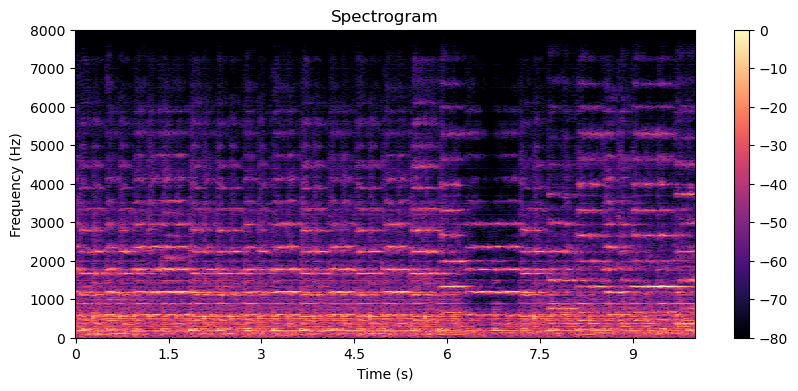

In [441]:
import librosa

X_pred = librosa.stft(audio_pred_from_brain)
Xdb_pred = librosa.amplitude_to_db(abs(X_pred), ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(Xdb_pred, sr=16000, x_axis='time', y_axis='hz',)
plt.colorbar()
plt.title('Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
plt.savefig(os.path.join(path_to_save, f'{file_name}.png'))
plt.show()


In [442]:
from moviepy.editor import ImageClip, AudioFileClip

# Load the image and audio
image_clip = ImageClip(path_to_save+file_name+'.png').set_duration(10)  # Duration should match the audio length
audio_clip = AudioFileClip(path_to_save+file_name+'.wav')

# Combine them into a video
video = image_clip.set_audio(audio_clip)
video.write_videofile(path_to_save+file_name+'.mp4', fps=24)

huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


Moviepy - Building video /home/matteoc/genre-to-fmri/to_nicola/classical.00071.mp4.
MoviePy - Writing audio in classical.00071TEMP_MPY_wvf_snd.mp3


huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)
huggingface/tokenizers: The current process just got forked, after parallelism has already been used. Disabling parallelism to avoid deadlocks...
To disable this warning, you can either:
	- Avoid using `tokenizers` before the fork if possible
	- Explicitly set the environment variable TOKENIZERS_PARALLELISM=(true | false)


MoviePy - Done.
Moviepy - Writing video /home/matteoc/genre-to-fmri/to_nicola/classical.00071.mp4



Moviepy - Done !
Moviepy - video ready /home/matteoc/genre-to-fmri/to_nicola/classical.00071.mp4


In [443]:
audio_vera = pipe(prompt_embeds=test_text_feat_avg_aligned[start_track:stop_track], num_inference_steps=50, audio_length_in_s=10.0).audios[0]
audio_vera_wav = librosa.load(test_stim_name_avg_aligned[:60][start_track:stop_track][0], sr=16000)

100%|██████████| 50/50 [00:01<00:00, 36.80it/s]


In [444]:
Audio(audio_vera_wav[0][0:160000], rate=16000)

In [549]:
Audio(audio_vera, rate=16000)

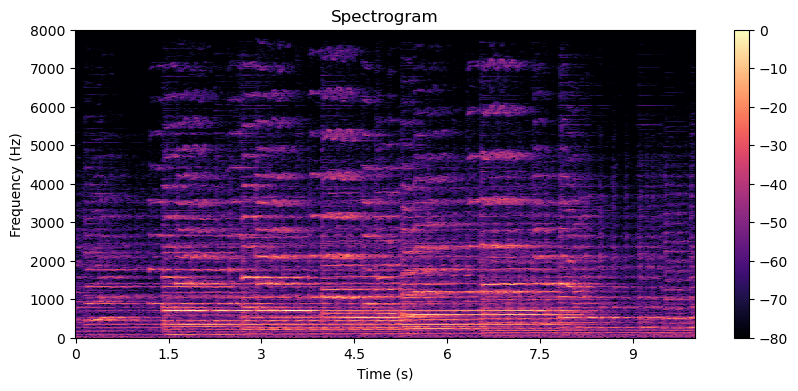

In [445]:
X_vera = librosa.stft(audio_vera_wav[0][0:160000])
Xdb_vera = librosa.amplitude_to_db(abs(X_vera), ref=np.max)
plt.figure(figsize=(10, 4))
librosa.display.specshow(Xdb_vera, sr=16000, x_axis='time', y_axis='hz',)
plt.colorbar()
plt.title('Spectrogram')
plt.xlabel('Time (s)')
plt.ylabel('Frequency (Hz)')
# plt.savefig(os.path.join(path_to_save, f'{file_name}.png'))
plt.show()

## Identification Accuracy

In [28]:
from scipy.stats import pearsonr

def identification_accuracy(P, T):
    n = P.shape[0]
    C = np.zeros((n, n))
    
    # Compute the correlation matrix
    for i in tqdm.trange(n):
        for j in range(n):
            C[i, j], _ = pearsonr(P[i], T[j])
    
    # Compute identification accuracy per prediction
    id_acc = np.zeros(n)
    for i in tqdm.trange(n):
        id_acc[i] = (C[i, i] > C[i]).sum() 
        id_acc[i] = id_acc[i] / (n - 1)

    # Average identification accuracy
    overall_id_acc = np.mean(id_acc)
    
    return overall_id_acc

In [29]:
id_accs = []

id_accs=[]
for i in range(5):
    
    id_acc=identification_accuracy(audio_feat_to_generate[60*i:60*(i+1)].cpu(),test_feature_finetuned[60*i:60*(i+1)].cpu())
    id_accs.append(id_acc)

mean_acc = np.mean(id_accs)
std_acc = np.std(id_accs)

np.mean(id_accs), np.std(id_accs)

print(mean_acc, std_acc)

100%|██████████| 60/60 [00:00<00:00, 233232.85it/s]

0.8834463276836159 0.01912961312665018


## Similarity Metrics

In [50]:
import seaborn as sns
import matplotlib.pyplot as plt

# def cosine_similarity(vec1, vec2, temperature=Null):
#     dot_product = np.dot(vec1, vec2)
#     norm_vec1 = np.linalg.norm(vec1)
#     norm_vec2 = np.linalg.norm(vec2)
#     return dot_product / (norm_vec1 * norm_vec2)

def cosine_similarity(vec1, vec2, temperature):
    logits = (vec1 @ vec2.T) / temperature

    return logits

def compute_cosine_matrix(real_embeddings, predicted_embeddings):
    num_real = real_embeddings.shape[0]
    num_pred = predicted_embeddings.shape[0]
    similarity_matrix = np.zeros((num_real, num_pred))
    real_embeddings = nn.functional.normalize(real_embeddings, dim=1)
    predicted_embeddings = nn.functional.normalize(predicted_embeddings, dim=1)
    
    for i in range(num_real):
        for j in range(num_pred):
            similarity_matrix[i, j] = (real_embeddings[i] @ predicted_embeddings[j].T) / 1
            # similarity_matrix[i, j] = cosine_similarity(real_embeddings[i], predicted_embeddings[j], 1)
    
    return similarity_matrix


def compute_cosine_matrix_SGCD(real_embeddings, predicted_embeddings):
    num_real = real_embeddings.shape[0]
    num_pred = predicted_embeddings.shape[0]
    similarity_matrix = np.zeros((num_real, num_pred))
    
    real_embeddings = torch.nn.functional.normalize(real_embeddings, dim=1)
    predicted_embeddings = torch.nn.functional.normalize(predicted_embeddings, dim=1)
    
    for i in range(num_real):
        for j in range(num_pred):
            input_normed = real_embeddings[i].unsqueeze(0)  # Add batch dimension
            embed_normed = predicted_embeddings[j].unsqueeze(0)  # Add batch dimension
            dists = input_normed.sub(embed_normed).norm(dim=1).div(2).arcsin().pow(2).mul(2)  # Squared Great Circle Distance
            similarity_matrix[i, j] = dists.mean()
    
    return similarity_matrix

def plot_similarity_matrix(similarity_matrix):
    plt.figure(figsize=(7,4))
    # sns.heatmap(similarity_matrix, annot=False, cmap='coolwarm')
    sns.heatmap(similarity_matrix, vmin=-0.3, vmax=1, annot=False, cmap='coolwarm')
    # sns.heatmap(similarity_matrix, vmin=0, vmax=1.5, annot=False, cmap='coolwarm_r')
    plt.xlabel('Predicted Embeddings')
    plt.ylabel('Real Embeddings')
    plt.title('Cosine Similarity between Real and Predicted Embeddings')
    plt.show()



0.9676440954208374
-0.21150243282318115


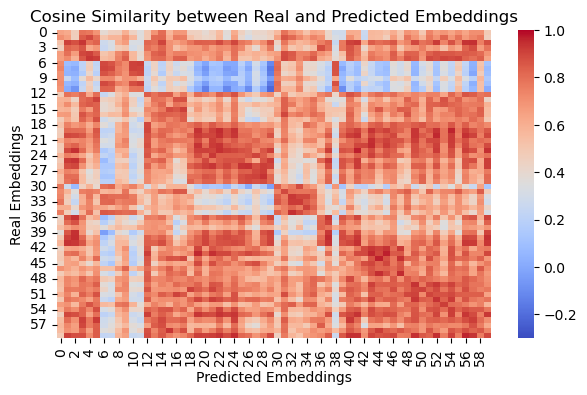

0.9630329608917236
-0.1105610728263855


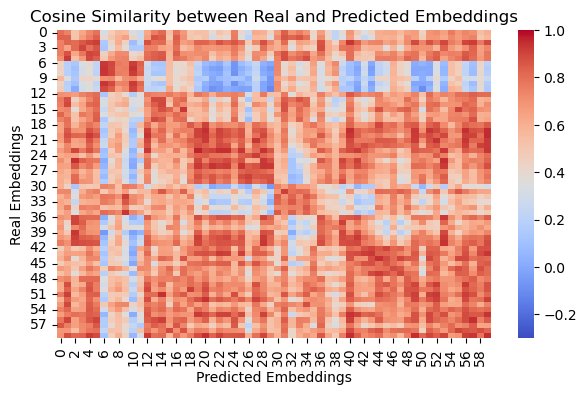

0.965211808681488
-0.2002921849489212


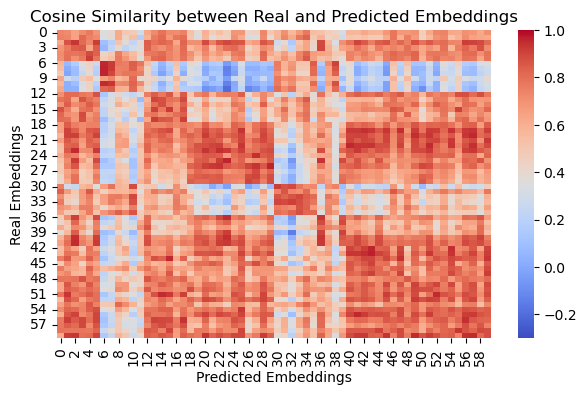

0.9724320769309998
-0.12441989034414291


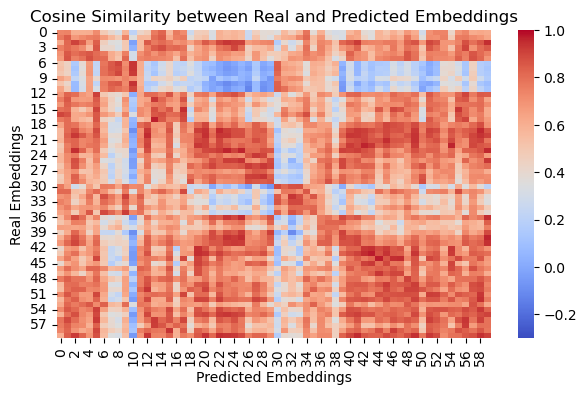

0.963132381439209
-0.2728964686393738


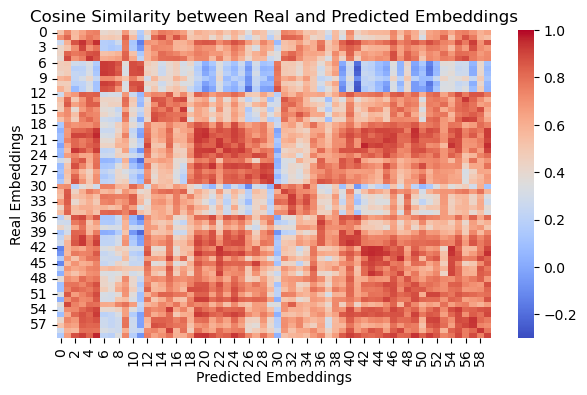

In [51]:
for i in range(5):
    
    similarity_matrix = compute_cosine_matrix(test_feature_finetuned[60*i:60*(i+1)].cpu(), audio_feat_to_generate[60*i:60*(i+1)].cpu())
    print(np.max(similarity_matrix))
    print(np.min(similarity_matrix))
    plot_similarity_matrix(similarity_matrix)
